In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option('display.max_colwidth', 300)
# pd.set_option('display.max_rows', 100)

## Adatok beolvasása

In [3]:
df_public_train = pd.read_csv('./public_train.csv')
df_public_train.head()

,ID,DEFAULT,SECTOR,SUBSECTOR,O1000,O1200,O6000,P1000,P3000,P5000,...,UK,PH,KKV,EXPOSURE,SIZE_CAT,EXPSHARE,DUR,ENTITY,MONTH,DAY
0,1,0,BI,I,603051.0,0.000,18633.0,16993.0,18483.0,19377.0,...,0.0000,2.0,1.0,2467997.0,kat4,0.0,4.9,entity1,6,30
1,2,0,BE,D,310318.0,0.000,4255.0,14485.0,17362.0,14778.0,...,0.0034,2.0,1.0,1327827.0,kat3,0.0,1.0,entity2,11,8
2,3,0,BI,K,19711743.0,4566341.638,41305.0,290507.0,205264.0,172007.0,...,0.0000,2.0,2.0,0.0,kat4,22.2,3.7,entity3,4,7
3,4,0,BJ,G,165567.0,0.000,5542.0,9638.0,8899.0,6720.0,...,3.9114,2.0,1.0,23902288.0,kat3,0.0,0.0,entity3,3,2
4,5,0,BH,C,3212773.0,2987.000,53149.0,22350.0,-23309.0,-24611.0,...,NaN,NaN,NaN,NaN,kat6,0.1,NaN,entity6,3,31


In [4]:
df_public_test = pd.read_csv('./public_test.csv')
df_public_test.head()

,ID,SECTOR,SUBSECTOR,O1000,O1200,O6000,P1000,P3000,P5000,N1000,...,UK,PH,KKV,EXPOSURE,SIZE_CAT,EXPSHARE,DUR,ENTITY,MONTH,DAY
0,19780,AN,D,22897.0,0.0,308.0,507.0,223.0,156.0,3042.0,...,5.1536,2.0,1.0,3.028097e+06,kat2,0.0,1.0,entity4,7,6
1,19781,BJ,G,27595080.0,27810555.0,60814.0,838860.0,775822.0,733274.0,5621939.0,...,1.0328,2.0,1.0,1.913730e+09,kat4,99.3,0.0,entity3,8,7
2,19782,AF,C,698068.0,0.0,158594.0,164975.0,158143.0,154796.0,1361694.0,...,2.5000,2.0,1.0,2.253064e+06,kat5,0.0,4.8,entity8,1,2
3,19783,CA,D,122553.0,0.0,10627.0,26570.0,21999.0,19905.0,120633.0,...,NaN,NaN,NaN,NaN,kat3,0.0,3.0,entity11,1,3
4,19784,CI,C,62371.0,10884.0,24387.0,-9284.0,-13734.0,-13505.0,-10187.0,...,3.9133,2.0,1.0,1.263284e+07,kat2,17.6,4.2,entity12,1,3


In [5]:
df_public_train['TRAIN_OR_TEST'] = 'train'
df_public_test['TRAIN_OR_TEST'] = 'test'
df_orig_all = pd.concat([df_public_train, df_public_test])

## Adatelőkészítés

### Konstans oszlopok kiszűrése

In [6]:
for column in df_orig_all.columns:
    if df_orig_all[column].nunique() == 1:
        print(column)

### Hiányzó értékek

In [7]:
df_orig_all.describe(include='all')

,ID,DEFAULT,SECTOR,SUBSECTOR,O1000,O1200,O6000,P1000,P3000,P5000,...,PH,KKV,EXPOSURE,SIZE_CAT,EXPSHARE,DUR,ENTITY,MONTH,DAY,TRAIN_OR_TEST
count,39557.000000,19779.000000,39557,39557,3.955600e+04,3.955700e+04,3.935700e+04,3.953000e+04,3.953000e+04,3.953000e+04,...,37368.000000,37368.000000,3.667800e+04,39557,39172.000000,39131.000000,39557,39557.000000,39557.000000,39557
unique,NaN,NaN,80,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,NaN,NaN,170,NaN,NaN,2
top,NaN,NaN,BI,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,kat2,NaN,NaN,entity2,NaN,NaN,train
freq,NaN,NaN,4820,11188,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10553,NaN,NaN,7195,NaN,NaN,19779
mean,19779.000000,0.093736,NaN,NaN,1.154126e+06,3.436659e+05,3.627991e+04,6.116628e+04,6.160165e+04,5.735112e+04,...,1.992132,1.041800,2.764759e+07,NaN,1.970647,3.136012,NaN,6.528023,16.298278,NaN
std,11419.266636,0.291468,NaN,NaN,1.829822e+07,9.379062e+06,5.714851e+05,1.246786e+06,1.346431e+06,1.284223e+06,...,0.088352,0.200136,2.751038e+08,NaN,11.418802,3.549216,NaN,3.364236,8.754621,NaN
min,1.000000,0.000000,NaN,NaN,0.000000e+00,-1.364620e+02,-5.110000e+03,-2.645981e+07,-2.612563e+07,-2.631799e+07,...,1.000000,1.000000,0.000000e+00,NaN,0.000000,0.000000,NaN,1.000000,1.000000,NaN
25%,9890.000000,0.000000,NaN,NaN,3.859975e+04,0.000000e+00,9.430000e+02,1.436000e+03,1.108250e+03,8.580000e+02,...,2.000000,1.000000,9.053130e+05,NaN,0.000000,1.000000,NaN,4.000000,9.000000,NaN
50%,19779.000000,0.000000,NaN,NaN,1.213215e+05,0.000000e+00,2.928000e+03,6.261500e+03,5.427000e+03,4.782000e+03,...,2.000000,1.000000,2.720018e+06,NaN,0.000000,2.300000,NaN,6.000000,16.000000,NaN
75%,29668.000000,0.000000,NaN,NaN,3.753110e+05,0.000000e+00,9.929000e+03,2.389400e+04,2.256250e+04,2.075200e+04,...,2.000000,1.000000,7.631045e+06,NaN,0.000000,4.900000,NaN,9.000000,24.000000,NaN


In [8]:
# Count of NaN values per feature
df_orig_all.isna().sum()

ID                      0
DEFAULT             19778
SECTOR                  0
SUBSECTOR               0
O1000                   1
O1200                   0
O6000                 200
P1000                  27
P3000                  27
P5000                  27
N1000                   2
N1100                   1
N1300                   1
N3000                  53
N3200                   1
N3300                   1
M0000                   1
M1100                   0
M1200                   1
M1300                   1
M2200                   0
M2300                   0
M2400                   1
CONTRACT_SUM            0
CONTRACT_TYPE           0
CONTRACT_SUBTYPE        0
DIM_DENOM_DEV_ID        0
MODE                   46
FREQ                   47
UK                   3532
PH                   2189
KKV                  2189
EXPOSURE             2879
SIZE_CAT                0
EXPSHARE              385
DUR                   426
ENTITY                  0
MONTH                   0
DAY         

In [9]:
def add_missing_column(input_df, column):
    df = input_df.copy()
    new_column = f'{column}_WAS_MISSING'
    df.loc[:, new_column] = df[column].map(lambda x: 1 if pd.isna(x) else 0)
    return df

In [10]:
# Feltöltés átlaggal + új oszlop hozzáadása
def replace_with_mean(input_df, column):
    df = add_missing_column(input_df, column)
    mean = df[column].mean()
    df[column].fillna(mean, inplace=True)
    return df

In [11]:
# Feltöltés módusszal + új oszlop hozzáadása
def replace_with_mode(input_df, column):
    df = add_missing_column(input_df, column)
    mode = df[column].mode()[0]
    df[column].fillna(mode, inplace=True)
    return df

In [12]:
# O1000
df_orig_all = df_orig_all.dropna(subset=['O1000'])

In [13]:
# Replace missing numerical values
columns_to_replace = ['UK', 'PH', 'KKV', 'EXPOSURE', 'EXPSHARE', 'DUR', 'O6000', 'P1000',
                      'P3000', 'P5000', 'N1000', 'N3000', 'M1200', 'M1300', 'M2400']
for column in columns_to_replace:
    df_orig_all = replace_with_mean(df_orig_all, column)

In [14]:
df_orig_all['MODE'].unique()

array(['N', 'L', 'G', 'C', 'F', 'P', 'J', 'H', 'B', 'I', 'D', 'O', 'K',
       nan, 'M', 'E'], dtype=object)

In [15]:
df_orig_all['FREQ'].unique()

array(['B', 'F', 'C', 'H', 'E', 'D', nan, 'G'], dtype=object)

In [16]:
# Replace missing categorical values
columns_to_replace = ['MODE', 'FREQ']
for column in columns_to_replace:
    df_orig_all = replace_with_mode(df_orig_all, column)

In [17]:
# NaN elemek száma a DataFrame-ben
df_orig_all.isna().sum()

ID                          0
DEFAULT                 19778
SECTOR                      0
SUBSECTOR                   0
O1000                       0
O1200                       0
O6000                       0
P1000                       0
P3000                       0
P5000                       0
N1000                       0
N1100                       0
N1300                       0
N3000                       0
N3200                       0
N3300                       0
M0000                       0
M1100                       0
M1200                       0
M1300                       0
M2200                       0
M2300                       0
M2400                       0
CONTRACT_SUM                0
CONTRACT_TYPE               0
CONTRACT_SUBTYPE            0
DIM_DENOM_DEV_ID            0
MODE                        0
FREQ                        0
UK                          0
PH                          0
KKV                         0
EXPOSURE                    0
SIZE_CAT  

In [18]:
df_orig_all.head()

,ID,DEFAULT,SECTOR,SUBSECTOR,O1000,O1200,O6000,P1000,P3000,P5000,...,P1000_WAS_MISSING,P3000_WAS_MISSING,P5000_WAS_MISSING,N1000_WAS_MISSING,N3000_WAS_MISSING,M1200_WAS_MISSING,M1300_WAS_MISSING,M2400_WAS_MISSING,MODE_WAS_MISSING,FREQ_WAS_MISSING
0,1,0.0,BI,I,603051.0,0.000,18633.0,16993.0,18483.0,19377.0,...,0,0,0,0,0,0,0,0,0,0
1,2,0.0,BE,D,310318.0,0.000,4255.0,14485.0,17362.0,14778.0,...,0,0,0,0,0,0,0,0,0,0
2,3,0.0,BI,K,19711743.0,4566341.638,41305.0,290507.0,205264.0,172007.0,...,0,0,0,0,0,0,0,0,0,0
3,4,0.0,BJ,G,165567.0,0.000,5542.0,9638.0,8899.0,6720.0,...,0,0,0,0,0,0,0,0,0,0
4,5,0.0,BH,C,3212773.0,2987.000,53149.0,22350.0,-23309.0,-24611.0,...,0,0,0,0,0,0,0,0,0,0


### Kiugró értékek

In [19]:
# Nem ismerem az adatokat, így nem tudom eldönteni mi számít kiugrónak

### Kategorikus oszlopok kódolása

In [20]:
def dummy_encode(input_df, column, limit, drop_last=True):
    df = input_df.copy()
    unique_count = df[column].nunique()
    if (drop_last is True and unique_count <= limit):
        limit = unique_count - 1
    values = list(df[column].value_counts().index.values[:limit])
    for value in values:
        df[f'{column}={value}'] = df[column].map(lambda x: 1 if x == value else 0)
    return df

In [21]:
# Kategorikus változók listázása
df_orig_all.dtypes.where(lambda x: x == object).dropna()

SECTOR              object
SUBSECTOR           object
CONTRACT_TYPE       object
CONTRACT_SUBTYPE    object
DIM_DENOM_DEV_ID    object
MODE                object
FREQ                object
SIZE_CAT            object
ENTITY              object
TRAIN_OR_TEST       object
dtype: object

#### Sector

In [22]:
# TODO: ezt még lehet próbálgatni más értékekkel
df_orig_all['SECTOR'].value_counts().where(lambda x: x > 100).dropna()

BI    4820.0
BJ    4670.0
BG    2509.0
BK    2188.0
CA    1785.0
BH    1762.0
BE    1608.0
AC    1271.0
CD    1258.0
AQ    1158.0
CQ    1050.0
CC    1012.0
BQ     865.0
BV     832.0
CB     763.0
BF     737.0
AB     712.0
AF     659.0
AH     564.0
CM     527.0
CN     502.0
BN     474.0
AN     426.0
AT     415.0
AY     370.0
CG     365.0
CI     339.0
CF     337.0
CL     322.0
CP     294.0
AJ     284.0
BZ     261.0
AW     255.0
BP     249.0
AO     203.0
DA     197.0
BR     191.0
AX     188.0
BC     181.0
CX     174.0
CZ     161.0
AR     151.0
BW     147.0
AZ     146.0
AS     144.0
CJ     140.0
CE     136.0
CU     134.0
CK     132.0
BS     132.0
BU     127.0
AI     122.0
AE     121.0
AL     119.0
AU     118.0
AD     114.0
Name: SECTOR, dtype: float64

In [23]:
df_orig_all = dummy_encode(df_orig_all, 'SECTOR', 56)

#### Subsector

In [24]:
df_orig_all['SUBSECTOR'].value_counts()

C    11188
D    10878
E     3423
F     3245
I     2876
K     2863
B     2012
G     1483
H     1425
J      159
A        4
Name: SUBSECTOR, dtype: int64

In [25]:
df_orig_all = dummy_encode(df_orig_all, 'SUBSECTOR', 9)

#### CONTRACT_TYPE

In [26]:
df_orig_all['CONTRACT_TYPE'].value_counts()

C    21802
A    15610
D     1222
B      922
Name: CONTRACT_TYPE, dtype: int64

In [27]:
df_orig_all = dummy_encode(df_orig_all, 'CONTRACT_TYPE', 2)

#### CONTRACT_SUBTYPE

In [28]:
df_orig_all['CONTRACT_SUBTYPE'].value_counts()

C    17255
G    14196
D     6235
A     1350
F      452
B       31
H       22
I       14
E        1
Name: CONTRACT_SUBTYPE, dtype: int64

In [29]:
df_orig_all = dummy_encode(df_orig_all, 'CONTRACT_SUBTYPE', 5)

#### DIM_DENOM_DEV_ID

In [30]:
df_orig_all['DIM_DENOM_DEV_ID'].value_counts()

C    37180
B     2304
F       64
A        4
G        2
E        1
D        1
Name: DIM_DENOM_DEV_ID, dtype: int64

In [31]:
df_orig_all = dummy_encode(df_orig_all, 'DIM_DENOM_DEV_ID', 2)

#### MODE

In [32]:
df_orig_all['MODE'].value_counts()

L    14161
P     7355
C     5462
F     3776
J     2461
G     2408
I     1012
H      944
D      940
B      502
N      355
K      111
O       61
M        7
E        1
Name: MODE, dtype: int64

In [33]:
df_orig_all = dummy_encode(df_orig_all, 'MODE', 10)

#### FREQ

In [34]:
df_orig_all['FREQ'].value_counts()

F    16655
B    14783
C     6038
H     1769
E      236
D       73
G        2
Name: FREQ, dtype: int64

In [35]:
df_orig_all = dummy_encode(df_orig_all, 'FREQ', 4)

#### SIZE_CAT

In [36]:
df_orig_all['SIZE_CAT'].value_counts()

kat2    10553
kat3     8466
kat1     6878
kat4     6583
kat5     4363
kat6     1467
kat7      821
kat8      221
kat9      204
Name: SIZE_CAT, dtype: int64

In [37]:
df_orig_all = dummy_encode(df_orig_all, 'SIZE_CAT', 6)

#### ENTITY

In [38]:
df_orig_all['ENTITY'].value_counts().where(lambda x: x > 200).dropna()

entity2     7195.0
entity16    4762.0
entity10    3920.0
entity13    2698.0
entity12    2575.0
entity25    1614.0
entity14    1320.0
entity18    1171.0
entity24    1145.0
entity34    1057.0
entity1     1018.0
entity38     976.0
entity3      932.0
entity21     748.0
entity9      636.0
entity8      435.0
entity15     323.0
entity85     296.0
entity31     288.0
entity45     251.0
entity46     243.0
entity42     224.0
entity59     214.0
entity50     204.0
entity37     203.0
Name: ENTITY, dtype: float64

In [39]:
df_orig_all = dummy_encode(df_orig_all, 'ENTITY', 25)

### Értékkészlet transzformáció

In [40]:
# https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
# Get column names first
columns = ['O1000', 'O1200', 'O6000', 'P1000', 'P3000', 'P5000', 'N1000', 'N1100', 'N1300', 'N3000',
           'N3200', 'N3300', 'M0000', 'M1100', 'M1200', 'M1300', 'M2200', 'M2300', 'M2400', 'CONTRACT_SUM',
           'UK', 'PH', 'KKV', 'EXPOSURE', 'EXPSHARE', 'DUR', 'MONTH', 'DAY']
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = df_orig_all.copy()
scaled_df[columns] = scaler.fit_transform(df_orig_all[columns])
scaled_df[columns] = pd.DataFrame(scaled_df, columns=columns)

## Modellparaméterek meghatározása

In [41]:
def cross_validate(input_df, target, input_columns):
    df = input_df.copy()
    df = df.reset_index()
    result = pd.DataFrame(columns=['learning_rate', 'n_estimators', 'max_depth', 'min_samples_split',
                                   'min_samples_leaf', 'avgAUC'])
    for learning_rate in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]:
        for n_estimators in [100, 200, 300, 400, 500]:
            for max_depth in [3, 5, 9]:
                for min_samples_split in [2, 3, 5, 9, 15]:
                    for min_samples_leaf in [1, 3, 5, 9, 15]:
                        auc_scores = []
                        model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators,
                                                           max_depth=max_depth, min_samples_split=min_samples_split,
                                                           min_samples_leaf=min_samples_leaf, random_state=42)
                        for i in range(0, 20):
                            df_current_test = df[df['index'] % 20 == i]
                            df_current_train = df[df['index'] % 20 != i]
                            model.fit(df_current_train[input_columns], df_current_train[target])
                            df_current_test['pred'] = model.predict_proba(df_current_test[input_columns])[:,1]
                            auc = roc_auc_score(df_current_test[target], df_current_test['pred'])
                            auc_scores.append(auc)
                        avgAUC = np.mean(auc_scores)
                        result = result.append({'learning_rate': learning_rate, 'n_estimators': n_estimators,
                                                'max_depth': max_depth, 'min_samples_split': min_samples_split,
                                                'min_samples_leaf': min_samples_leaf, 'avgAUC': avgAUC}, ignore_index=True)
    return result

In [42]:
df_orig_all.describe(include='all')

,ID,DEFAULT,SECTOR,SUBSECTOR,O1000,O1200,O6000,P1000,P3000,P5000,...,ENTITY=entity8,ENTITY=entity15,ENTITY=entity85,ENTITY=entity31,ENTITY=entity45,ENTITY=entity46,ENTITY=entity42,ENTITY=entity59,ENTITY=entity50,ENTITY=entity37
count,39556.000000,19778.000000,39556,39556,3.955600e+04,3.955600e+04,3.955600e+04,3.955600e+04,3.955600e+04,3.955600e+04,...,39556.000000,39556.000000,39556.000000,39556.000000,39556.000000,39556.000000,39556.000000,39556.000000,39556.000000,39556.000000
unique,NaN,NaN,80,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,BI,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,4820,11188,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,19779.457503,0.093741,NaN,NaN,1.154126e+06,3.436746e+05,3.627991e+04,6.116628e+04,6.160165e+04,5.735112e+04,...,0.010997,0.008166,0.007483,0.007281,0.006345,0.006143,0.005663,0.005410,0.005157,0.005132
std,11419.048442,0.291475,NaN,NaN,1.829822e+07,9.379180e+06,5.700457e+05,1.246376e+06,1.345988e+06,1.283801e+06,...,0.104290,0.089995,0.086182,0.085018,0.079406,0.078138,0.075040,0.073355,0.071629,0.071455
min,1.000000,0.000000,NaN,NaN,0.000000e+00,-1.364620e+02,-5.110000e+03,-2.645981e+07,-2.612563e+07,-2.631799e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9890.750000,0.000000,NaN,NaN,3.859975e+04,0.000000e+00,9.490000e+02,1.438750e+03,1.110000e+03,8.590000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19779.500000,0.000000,NaN,NaN,1.213215e+05,0.000000e+00,2.954000e+03,6.274500e+03,5.434500e+03,4.788500e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29668.250000,0.000000,NaN,NaN,3.753110e+05,0.000000e+00,1.024450e+04,2.394800e+04,2.261850e+04,2.082350e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
print(list(df_orig_all.columns))

['ID', 'DEFAULT', 'SECTOR', 'SUBSECTOR', 'O1000', 'O1200', 'O6000', 'P1000', 'P3000', 'P5000', 'N1000', 'N1100', 'N1300', 'N3000', 'N3200', 'N3300', 'M0000', 'M1100', 'M1200', 'M1300', 'M2200', 'M2300', 'M2400', 'CONTRACT_SUM', 'CONTRACT_TYPE', 'CONTRACT_SUBTYPE', 'DIM_DENOM_DEV_ID', 'MODE', 'FREQ', 'UK', 'PH', 'KKV', 'EXPOSURE', 'SIZE_CAT', 'EXPSHARE', 'DUR', 'ENTITY', 'MONTH', 'DAY', 'TRAIN_OR_TEST', 'UK_WAS_MISSING', 'PH_WAS_MISSING', 'KKV_WAS_MISSING', 'EXPOSURE_WAS_MISSING', 'EXPSHARE_WAS_MISSING', 'DUR_WAS_MISSING', 'O6000_WAS_MISSING', 'P1000_WAS_MISSING', 'P3000_WAS_MISSING', 'P5000_WAS_MISSING', 'N1000_WAS_MISSING', 'N3000_WAS_MISSING', 'M1200_WAS_MISSING', 'M1300_WAS_MISSING', 'M2400_WAS_MISSING', 'MODE_WAS_MISSING', 'FREQ_WAS_MISSING', 'SECTOR=BI', 'SECTOR=BJ', 'SECTOR=BG', 'SECTOR=BK', 'SECTOR=CA', 'SECTOR=BH', 'SECTOR=BE', 'SECTOR=AC', 'SECTOR=CD', 'SECTOR=AQ', 'SECTOR=CQ', 'SECTOR=CC', 'SECTOR=BQ', 'SECTOR=BV', 'SECTOR=CB', 'SECTOR=BF', 'SECTOR=AB', 'SECTOR=AF', 'SECTOR=A

In [44]:
input_columns = ['O1000', 'O1200', 'O6000', 'P1000', 'P3000', 'P5000', 'N1000', 'N1100', 'N1300', 'N3000',
                 'N3200', 'N3300', 'M0000', 'M1100', 'M1200', 'M1300', 'M2200', 'M2300', 'M2400', 'CONTRACT_SUM',
                 'UK', 'PH', 'KKV', 'EXPOSURE', 'EXPSHARE', 'DUR', 'MONTH', 'DAY', 'UK_WAS_MISSING', 'PH_WAS_MISSING',
                 'KKV_WAS_MISSING', 'EXPOSURE_WAS_MISSING',
                 'EXPSHARE_WAS_MISSING', 'DUR_WAS_MISSING', 'O6000_WAS_MISSING', 'P1000_WAS_MISSING',
                 'P3000_WAS_MISSING', 'P5000_WAS_MISSING', 'N3000_WAS_MISSING', 'MODE_WAS_MISSING',
                 'FREQ_WAS_MISSING', 'SECTOR=BI', 'SECTOR=BJ', 'SECTOR=BG', 'SECTOR=BK', 'SECTOR=BH',
                 'SECTOR=CA', 'SECTOR=BE', 'SECTOR=AC', 'SECTOR=CD', 'SECTOR=AQ', 'SECTOR=CQ', 'SECTOR=CC',
                 'SECTOR=BQ', 'SECTOR=BV', 'SECTOR=CB', 'SECTOR=AB', 'SECTOR=AF', 'SECTOR=BF', 'SECTOR=AH',
                 'SECTOR=CN', 'SECTOR=CM', 'SECTOR=BN', 'SECTOR=AN', 'SECTOR=AT', 'SECTOR=AY', 'SECTOR=CG',
                 'SECTOR=CF', 'SECTOR=CL', 'SECTOR=CP', 'SECTOR=CI', 'SECTOR=AJ', 'SECTOR=BZ', 'SECTOR=AW',
                 'SECTOR=BP', 'SUBSECTOR=C', 'SUBSECTOR=D', 'SUBSECTOR=E', 'SUBSECTOR=F', 'SUBSECTOR=K',
                 'SUBSECTOR=I', 'SUBSECTOR=B', 'SUBSECTOR=H', 'SUBSECTOR=G', 'CONTRACT_TYPE=C', 'CONTRACT_TYPE=A',
                 'CONTRACT_SUBTYPE=C', 'CONTRACT_SUBTYPE=G', 'CONTRACT_SUBTYPE=D', 'CONTRACT_SUBTYPE=A',
                 'CONTRACT_SUBTYPE=F', 'DIM_DENOM_DEV_ID=C', 'DIM_DENOM_DEV_ID=B', 'MODE=L', 'MODE=P', 'MODE=C',
                 'MODE=F', 'MODE=J', 'MODE=G', 'MODE=I', 'MODE=H', 'FREQ=F', 'FREQ=B', 'FREQ=C', 'SIZE_CAT=kat2',
                 'SIZE_CAT=kat3', 'SIZE_CAT=kat1', 'SIZE_CAT=kat4', 'SIZE_CAT=kat5', 'SIZE_CAT=kat6', 'ENTITY=entity2',
                 'ENTITY=entity16', 'ENTITY=entity10', 'ENTITY=entity13', 'ENTITY=entity12', 'ENTITY=entity25',
                 'ENTITY=entity14', 'ENTITY=entity24', 'ENTITY=entity18', 'ENTITY=entity34', 'ENTITY=entity1',
                 'ENTITY=entity38', 'ENTITY=entity3', 'ENTITY=entity21', 'ENTITY=entity9', 'ENTITY=entity8']
target = 'DEFAULT'
df_train = scaled_df[scaled_df['TRAIN_OR_TEST'] == 'train'].copy()

In [46]:
# https://www.datacareer.de/blog/parameter-tuning-in-gradient-boosting-gbm/
p_test = {'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001], 'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750]}
tuning = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), 
             param_grid=p_test, scoring='roc_auc', n_jobs=-1, cv=10)

tuning.fit(df_train[input_columns], df_train[target])

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [54]:
# Legjobb paraméterek:
#  - learning_rate=0.05
#  - n_estimators=500
tuning.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 2}

In [49]:
# https://www.datacareer.de/blog/parameter-tuning-in-gradient-boosting-gbm/
p_test2 = {'max_depth':[2, 3, 4, 5, 6, 7] }
tuning = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, random_state=42), 
            param_grid=p_test2, scoring='roc_auc', n_jobs=-1, cv=10)

tuning.fit(df_train[input_columns], df_train[target])

GridSearchCV(cv=10,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  n_estimators=500,
                                                  random_state=42),
             n_jobs=-1, param_grid={'max_depth': [2, 3, 4, 5, 6, 7]},
             scoring='roc_auc')

In [50]:
# Legjobb paraméterek:
#  - max_depth=4
tuning.best_params_

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=500,
                           random_state=42)

In [51]:
# https://www.datacareer.de/blog/parameter-tuning-in-gradient-boosting-gbm/
p_test3 = {'min_samples_split': [2, 4, 6, 8, 10, 20, 40, 60, 100], 'min_samples_leaf':[1, 3, 5, 7, 9]}
tuning = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=4, random_state=42), 
            param_grid=p_test3, scoring='roc_auc', n_jobs=-1, cv=10)

tuning.fit(df_train[input_columns], df_train[target])

GridSearchCV(cv=10,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  max_depth=4, n_estimators=500,
                                                  random_state=42),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_samples_split': [2, 4, 6, 8, 10, 20, 40, 60,
                                               100]},
             scoring='roc_auc')

In [55]:
# Legjobb paraméterek:
#  - min_samples_split=2
#  - min_samples_leaf=5
tuning.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 2}

In [68]:
p_test4 = {'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
tuning = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=4,
                                                           min_samples_split=2, min_samples_leaf=5, random_state=42), 
                      param_grid=p_test4, scoring='roc_auc', n_jobs=-1, cv=10)

tuning.fit(df_train[input_columns], df_train[target])

GridSearchCV(cv=10,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  max_depth=4,
                                                  min_samples_leaf=5,
                                                  n_estimators=500,
                                                  random_state=42),
             n_jobs=-1,
             param_grid={'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20]},
             scoring='roc_auc')

In [69]:
# Legjobb paraméterek:
#  - max_features=10
tuning.best_params_

{'max_features': 10}

In [70]:
p_test5 = {'subsample': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]}
tuning = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=4,
                                                           min_samples_split=2, min_samples_leaf=5,
                                                           max_features=10, random_state=42), 
                      param_grid=p_test5, scoring='roc_auc', n_jobs=-1, cv=10)

tuning.fit(df_train[input_columns], df_train[target])

GridSearchCV(cv=10,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  max_depth=4, max_features=10,
                                                  min_samples_leaf=5,
                                                  n_estimators=500,
                                                  random_state=42),
             n_jobs=-1,
             param_grid={'subsample': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]},
             scoring='roc_auc')

In [71]:
# Legjobb paraméterek:
#  - subsample=1
tuning.best_params_

{'subsample': 1}

## Modellépítés

In [56]:
# df_cv_result = cross_validate(df_train, target, input_columns)
# df_cv_result

In [57]:
# Legjobb paraméterkombináció
# df_cv_result.loc[df_cv_result['avgAUC'].idxmax()]

# Tesztelés

In [72]:
df_train = scaled_df[scaled_df['TRAIN_OR_TEST'] == 'train'].copy()

In [73]:
model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500,
                                   max_depth=4, min_samples_split=2,
                                   min_samples_leaf=5, max_features=10,
                                   subsample=1, random_state=42)
model.fit(df_train[input_columns], df_train[target])
df_public_test, df_private_test = train_test_split(df_train, test_size=0.5)

In [74]:
df_public_test['pred'] = model.predict_proba(df_public_test[input_columns])[:,1]
df_private_test['pred'] = model.predict_proba(df_private_test[input_columns])[:,1]

D:\Programs\Anaconda\envs\Python_3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programs\Anaconda\envs\Python_3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
auc_scores = []
auc_scores.append(roc_auc_score(df_public_test[target], df_public_test['pred']))
auc_scores.append(roc_auc_score(df_private_test[target], df_private_test['pred']))
avg_auc = np.mean(auc_scores)
print(avg_auc)

0.9166338125020345


## Beküldés

In [76]:
df_test = scaled_df[scaled_df['TRAIN_OR_TEST'] == 'test'].copy()
df_test['PROBA_OF_DEFAULT'] = model.predict_proba(df_test[input_columns])[:,1]

<AxesSubplot:>

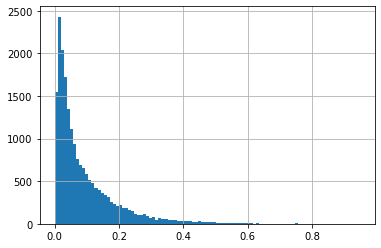

In [77]:
bekuldendo = df_test[['ID', 'PROBA_OF_DEFAULT']]
bekuldendo['PROBA_OF_DEFAULT'].hist(bins=100)

In [78]:
bekuldendo.to_csv('elso_megfejtesem_LL.csv', index=False)